In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19 Dataset"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CT  X-ray


In [ ]:

#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

In [ ]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

extensive_COVID_database_CT = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/CT")
extensive_COVID_database_X_Ray = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/X-ray")


# CT CNNs

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 16
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 8054 files belonging to 2 classes.
Using 5638 files for training.
Found 8054 files belonging to 2 classes.
Using 2416 files for validation.


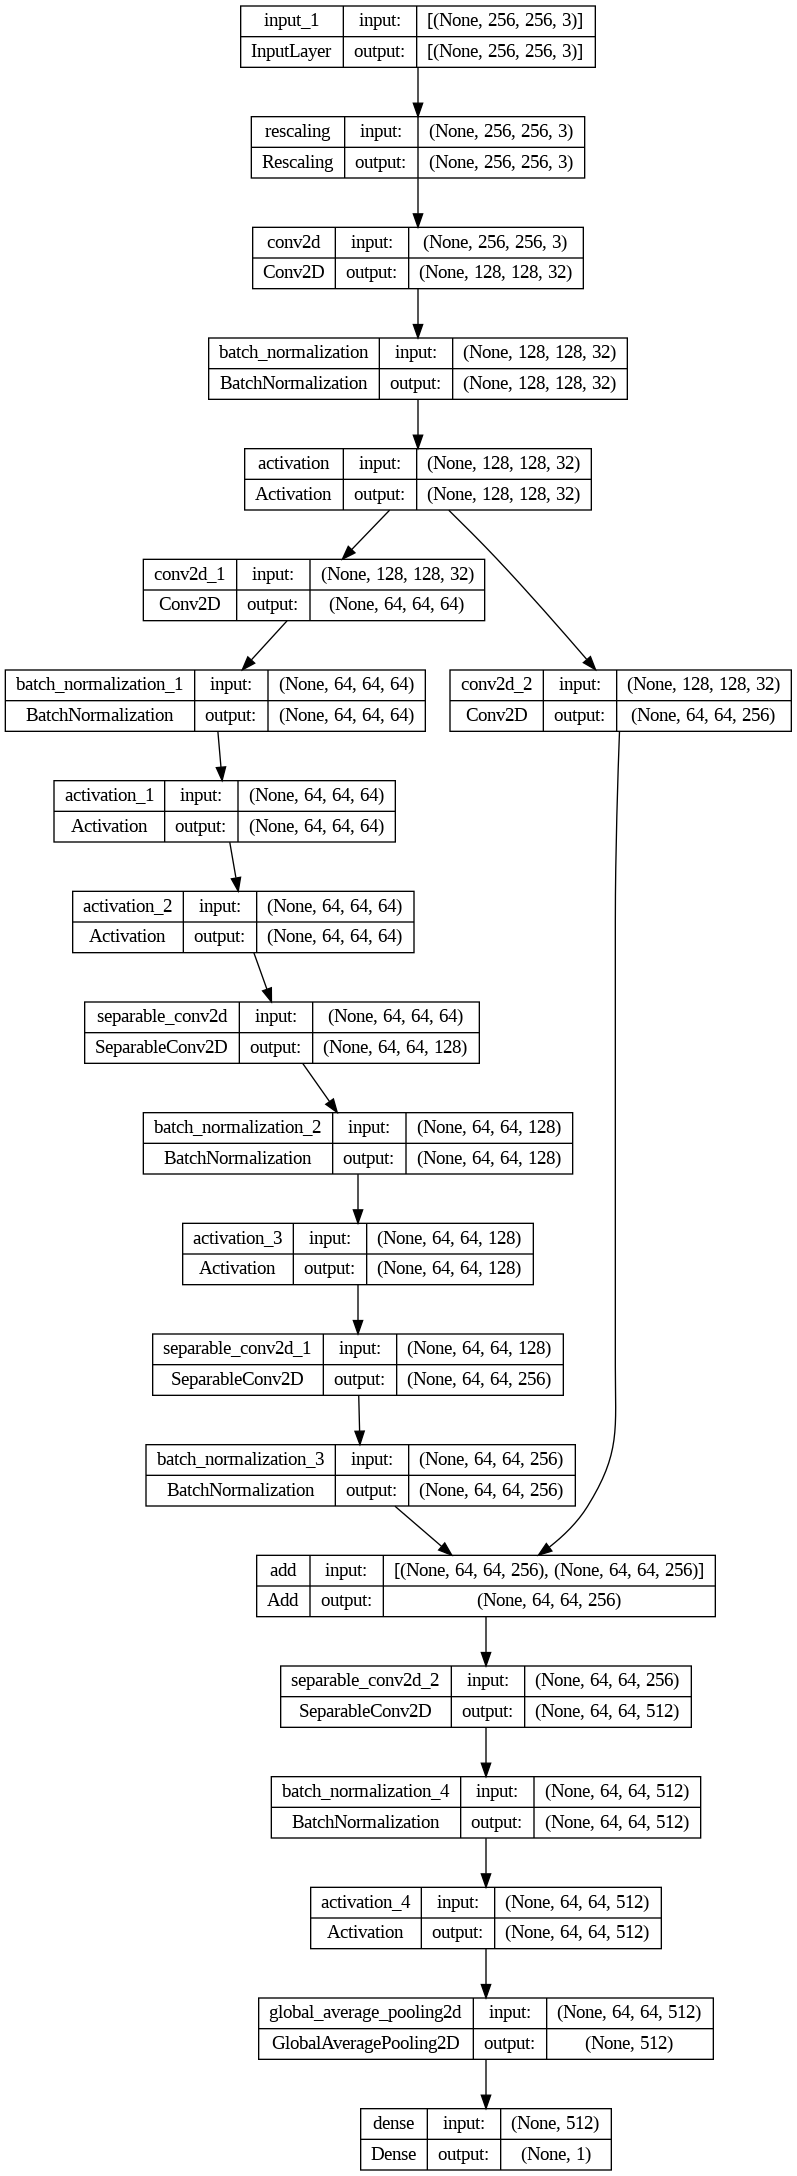

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

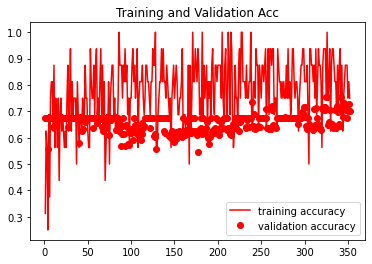

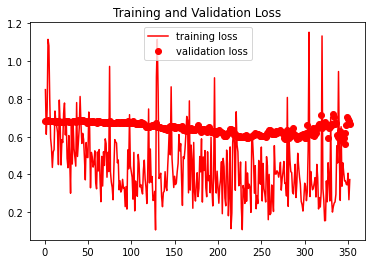

In [ ]:
epochs = 352

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_CT_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/352
1/1 [==============================] - 19s 19s/step - loss: 0.6498 - acc: 0.6250 - val_loss: 2.4880 - val_acc: 0.6763
Epoch 2/352
1/1 [==============================] - 14s 14s/step - loss: 1.7393 - acc: 0.5625 - val_loss: 0.7751 - val_acc: 0.6738
Epoch 3/352
1/1 [========================

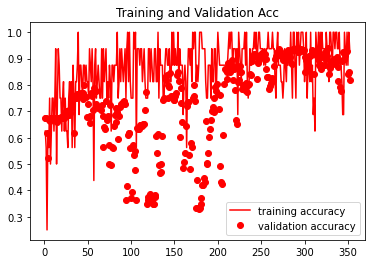

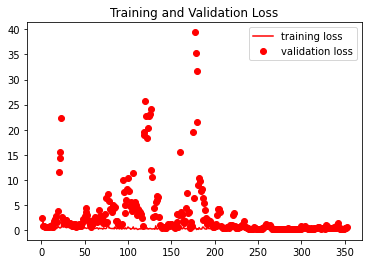

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 352

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_extensive_covid_Xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/352
1/1 [==============================] - 392s 392s/step - loss: 0.8369 - acc: 0.3125 - val_loss: 56.7943 - val_acc: 0.6763
Epoch 2/352
1/1 [==============================] - 10s 10s/step - loss: 2.6616 - acc: 0.6875 - val_loss: 

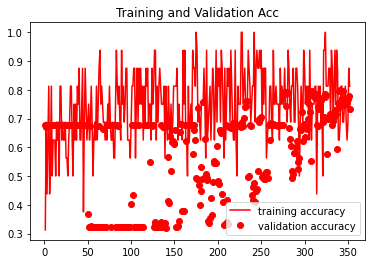

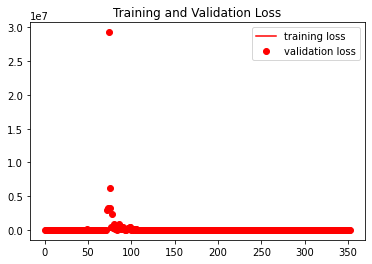

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 352

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_extensive_covid_Xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

82420632/82420632 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,659,553
Trainable params: 20,505,681
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/352
1/1 [==============================] - 36s 36s/step - loss: 0.7259 - acc: 0.3125 - val_loss: 0.6907 - val_acc: 0.5418
Epoch 2/352
1/1 [======================

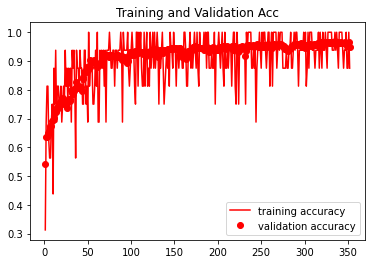

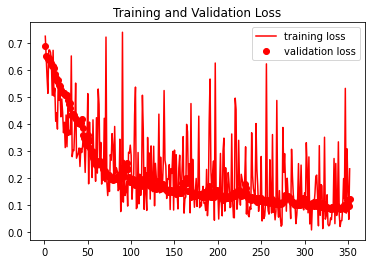

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 352

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.00001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_extensive_covid_Xrayy_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


# X-Ray CNNS

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 16
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 9537 files belonging to 2 classes.
Using 8584 files for training.
Found 9537 files belonging to 2 classes.
Using 953 files for validation.


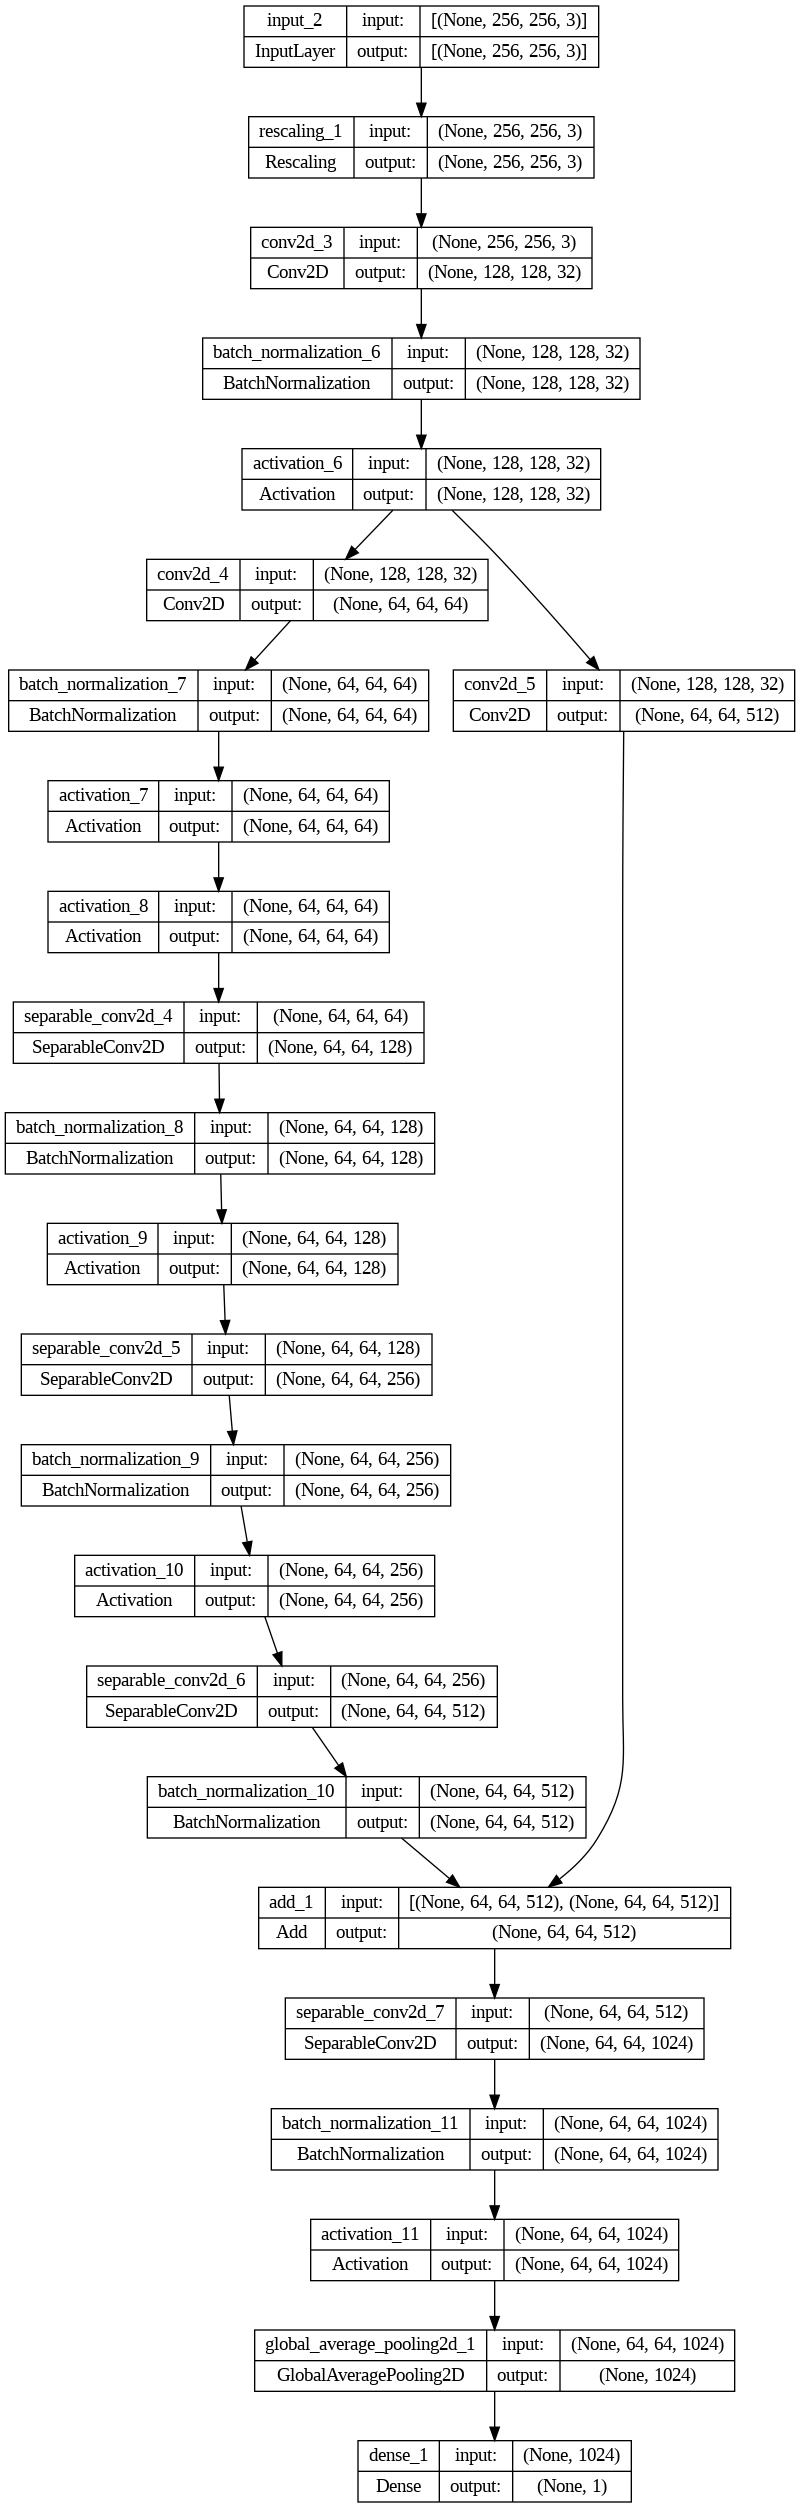

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

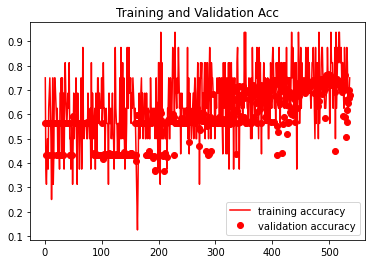

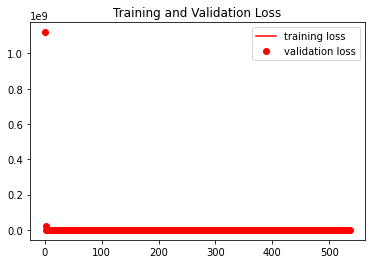

In [ ]:
epochs = 536

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.1,momentum=0.1),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_XRAY_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/536
1/1 [==============================] - 18s 18s/step - loss: 0.6938 - acc: 0.4375 - val_loss: 5735.8799 - val_acc: 0.5656
Epoch 2/536
1/1 [==============================] - 8s 8s/step - loss: 10.8163 - acc: 0.6250 - val_loss: 1

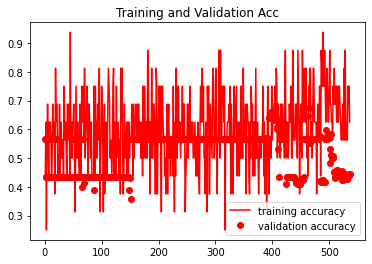

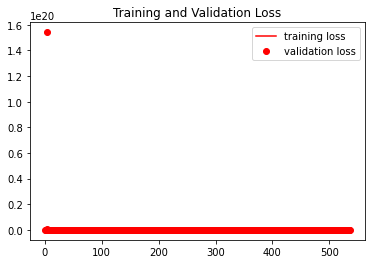

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 536

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_extensive_covid_Xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/536
1/1 [==============================] - 33s 33s/step - loss: 0.8602 - acc: 0.2500 - val_loss: 10586003394227339264.0000 - val_acc: 0.5656
Epoch 2/536
1/1 [==============================] - 8s 8s/step - loss: 27.2934 - acc: 0.

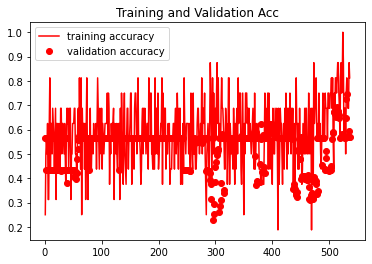

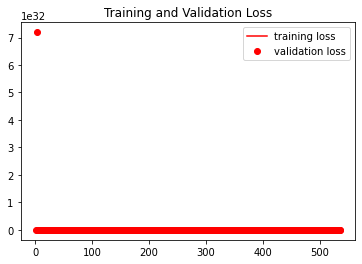

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 536

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_extensive_covid_Xray_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

82420632/82420632 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,659,553
Trainable params: 20,505,681
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/536
1/1 [==============================] - 51s 51s/step - loss: 0.6835 - acc: 0.5000 - val_loss: 1089.8708 - val_acc: 0.5226
Epoch 2/536
1/1 [===================

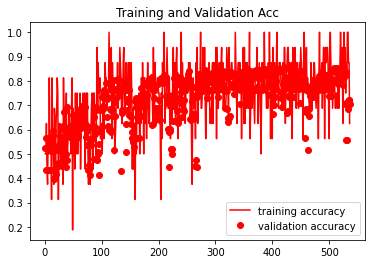

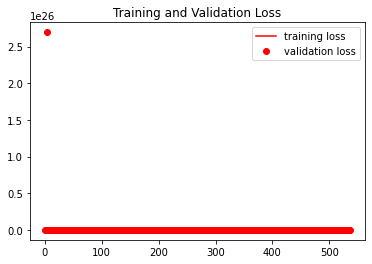

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 536

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=1,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_extensive_covid_Xrayy_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     
